In [39]:
import sys
sys.path.insert(0,'C:\\users\\alexa\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""

from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar

from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
reader = FamaFrenchReader("49_Industry_Portfolios", start=datetime.datetime(1970, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202210 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (634 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (634 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (52 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (52 rows x 49 cols)\n  4 : Number of Firms in Portfolios (634 rows x 49 cols)\n  5 : Average Firm Size (634 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (53 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (53 rows x 49 cols)'

In [41]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

In [42]:
mkt_index = (1 + market_return).cumprod()

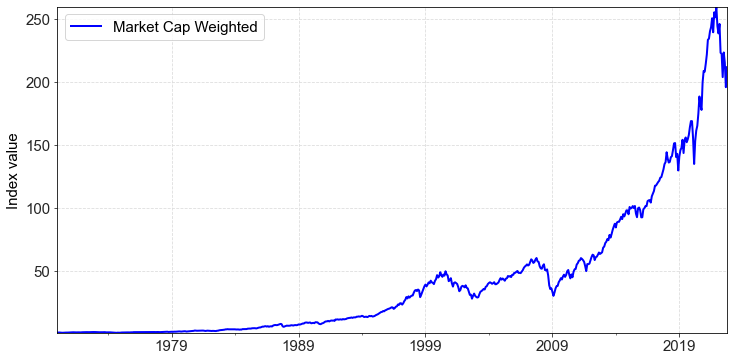

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))

mkt_index.plot(color="blue", label="Market Cap Weighted", xlabel="")
ax.set_ylabel("Index value")
ax.legend();

In [44]:
reader = FamaFrenchReader("49_Industry_Portfolios", start=datetime.datetime(1970, 1, 1))
industry_port = reader.read()


In [45]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()


# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()

asset_list = ind_mc_weighted.columns

#Define equally weight portfolio weights
w_eq = weights = np.repeat(1.0 / 49.0, 49)

In [46]:
"""
Calculate log returns
"""

log_returns = np.log(1+ind_eq_weighted)

In [47]:
mean_log_returns = log_returns.mean()
mean_log_returns

Agric    0.004471
Food     0.009804
Soda     0.011497
Beer     0.010364
Smoke    0.014975
Toys     0.005344
Fun      0.007496
Books    0.008277
Hshld    0.007321
Clths    0.007590
Hlth     0.008808
MedEq    0.008618
Drugs    0.011062
Chems    0.010180
Rubbr    0.010231
Txtls    0.005817
BldMt    0.009995
Cnstr    0.006673
Steel    0.007814
FabPr    0.005199
Mach     0.009838
ElcEq    0.008484
Autos    0.007233
Aero     0.011902
Ships    0.008123
Guns     0.013205
Gold     0.003535
Mines    0.007300
Coal     0.002381
Oil      0.007068
Util     0.010265
Telcm    0.009331
PerSv    0.006465
BusSv    0.009859
Hardw    0.008166
Softw    0.004637
Chips    0.010852
LabEq    0.011356
Paper    0.008179
Boxes    0.009635
Trans    0.008328
Whlsl    0.008191
Rtail    0.008345
Meals    0.007030
Banks    0.010113
Insur    0.010889
RlEst    0.005008
Fin      0.009971
Other    0.006061
dtype: float64

In [48]:
cov_mat_log_returns = log_returns.cov()
cov_mat_log_returns

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Agric,0.005166,0.002310,0.002202,0.002045,0.001722,0.003638,0.003674,0.003141,0.003252,0.003251,...,0.002914,0.003190,0.003480,0.003302,0.003345,0.002311,0.002336,0.003530,0.002740,0.003415
Food,0.002310,0.002031,0.001892,0.001680,0.001493,0.002644,0.002647,0.002338,0.002399,0.002451,...,0.002218,0.002325,0.002441,0.002560,0.002469,0.001726,0.001821,0.002455,0.001970,0.002407
Soda,0.002202,0.001892,0.004624,0.002042,0.001908,0.003110,0.002956,0.002616,0.002658,0.002790,...,0.002378,0.002476,0.002578,0.002954,0.002802,0.001846,0.001868,0.002816,0.002147,0.002709
Beer,0.002045,0.001680,0.002042,0.002881,0.001516,0.002604,0.002629,0.002227,0.002373,0.002398,...,0.002046,0.002182,0.002352,0.002423,0.002476,0.001651,0.001756,0.002513,0.001897,0.002390
Smoke,0.001722,0.001493,0.001908,0.001516,0.005093,0.002110,0.001923,0.001834,0.001943,0.002039,...,0.001753,0.001957,0.001988,0.002117,0.002048,0.001494,0.001617,0.002036,0.001662,0.001887
Toys,0.003638,0.002644,0.003110,0.002604,0.002110,0.006446,0.004846,0.003944,0.004220,0.004393,...,0.003469,0.003855,0.004210,0.004700,0.004330,0.002777,0.002729,0.004366,0.003459,0.004276
Fun,0.003674,0.002647,0.002956,0.002629,0.001923,0.004846,0.005902,0.004142,0.004166,0.004306,...,0.003509,0.003989,0.004311,0.004466,0.004518,0.002898,0.002852,0.004414,0.003494,0.004355
Books,0.003141,0.002338,0.002616,0.002227,0.001834,0.003944,0.004142,0.004649,0.003603,0.003723,...,0.003159,0.003475,0.003633,0.003847,0.003696,0.002567,0.002678,0.003712,0.003081,0.003600
Hshld,0.003252,0.002399,0.002658,0.002373,0.001943,0.004220,0.004166,0.003603,0.004147,0.003961,...,0.003262,0.003592,0.003767,0.003975,0.003902,0.002638,0.002626,0.003864,0.003118,0.003672
Clths,0.003251,0.002451,0.002790,0.002398,0.002039,0.004393,0.004306,0.003723,0.003961,0.004807,...,0.003325,0.003717,0.003871,0.004295,0.004153,0.002718,0.002698,0.004075,0.003172,0.003835


In [49]:
corr_mat_log_returns = cov_to_corr_matrix(cov_mat_log_returns)

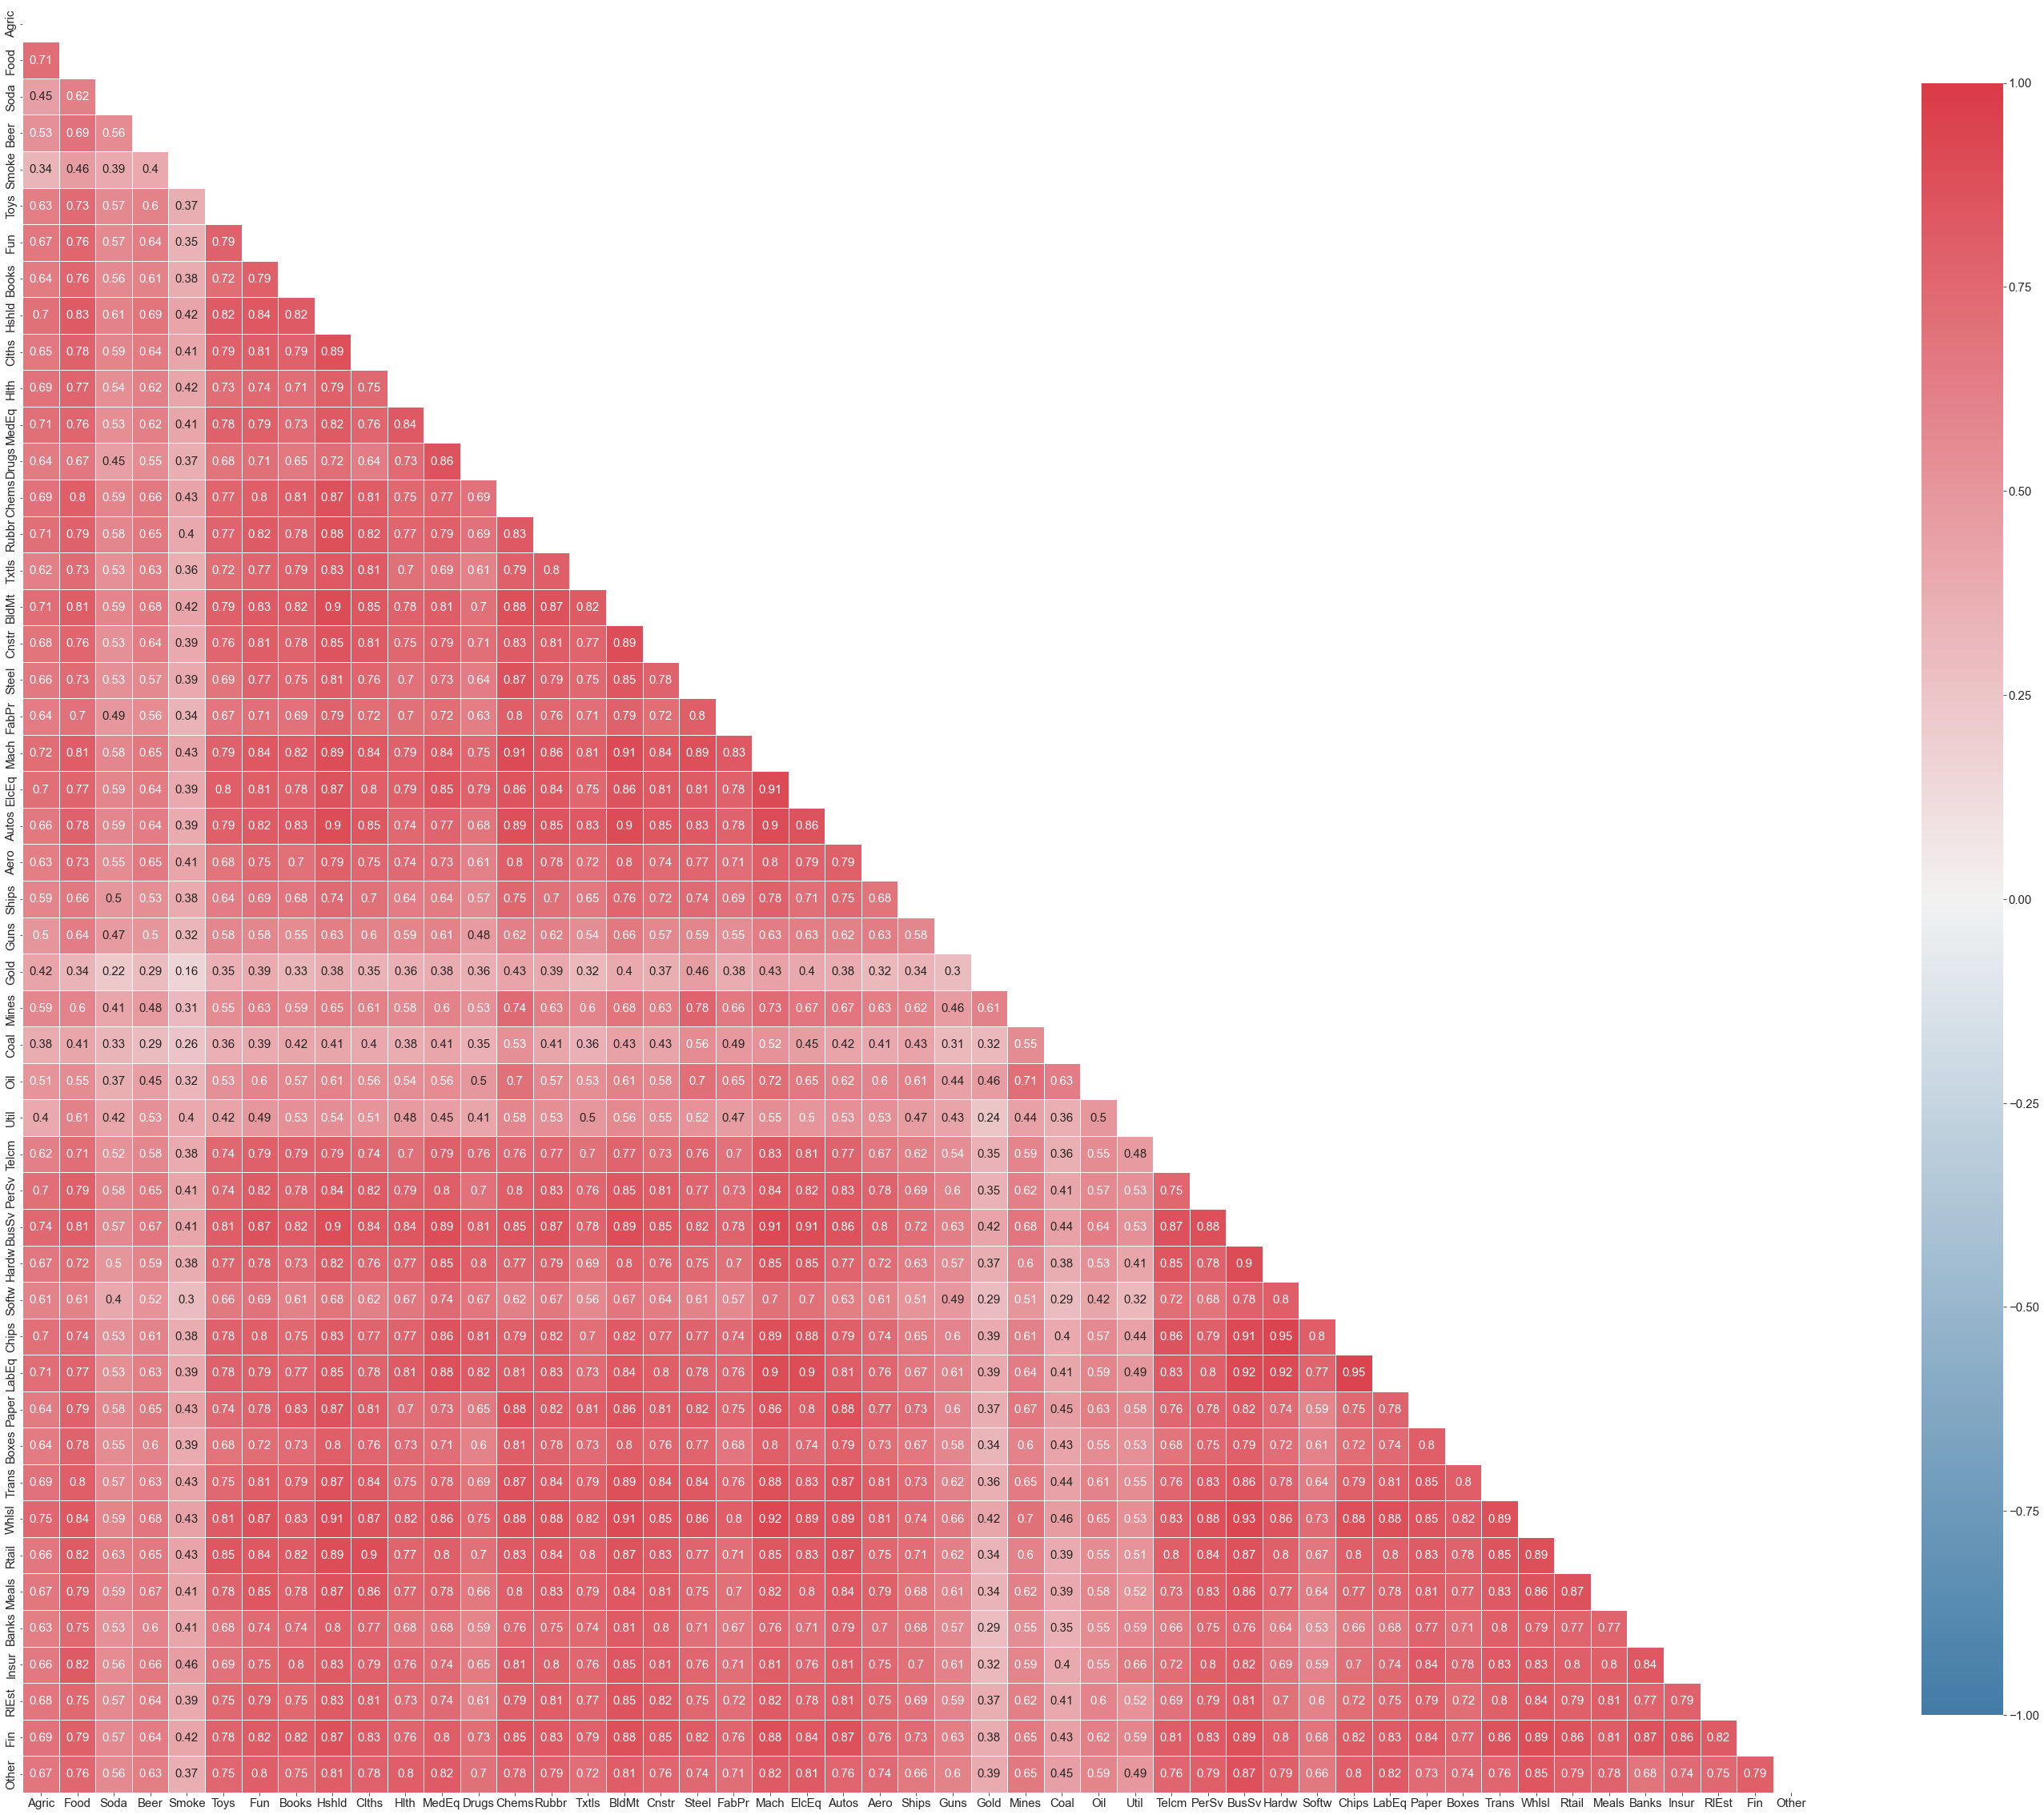

In [50]:
fig, ax = plt.subplots(figsize=(50, 50))
correlation_plot(corr_mat_log_returns, names=asset_list, include_values=True, ax=ax)

In [51]:
def calculate_marginal_risks_std(weights: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:
    
    """
    Function that calculates marginal risk
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    total_risk = np.sqrt(weights @ cov_matrix @ weights)
    inner_derivative = cov_matrix @ weights
    
    return inner_derivative / total_risk

def calculate_risk_contributions_std(weights: np.ndarray, cov_matrix: np.ndarray, scale: bool = False) -> np.ndarray:
    
    """
    Function that calculates risk contributions
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    mr = calculate_marginal_risks_std(weights, cov_matrix)
    
    if scale: 
        mr /= np.sqrt(weights @ cov_matrix @ weights)
    
    return weights * mr

In [52]:
print("relative risk contribution: ")
rel_risk_contrib = calculate_risk_contributions_std(w_eq, cov_mat_log_returns, scale=True)
rel_risk_contrib

relative risk contribution: 


Agric    0.018978
Food     0.013376
Soda     0.014876
Beer     0.013166
Smoke    0.011548
Toys     0.023245
Fun      0.023427
Books    0.020134
Hshld    0.020680
Clths    0.021137
Hlth     0.023241
MedEq    0.021752
Drugs    0.022326
Chems    0.019892
Rubbr    0.021145
Txtls    0.022194
BldMt    0.020716
Cnstr    0.023812
Steel    0.023120
FabPr    0.020834
Mach     0.022065
ElcEq    0.023026
Autos    0.024187
Aero     0.021056
Ships    0.022024
Guns     0.016448
Gold     0.019417
Mines    0.022100
Coal     0.020835
Oil      0.022845
Util     0.007478
Telcm    0.021780
PerSv    0.020951
BusSv    0.022428
Hardw    0.026959
Softw    0.027002
Chips    0.026605
LabEq    0.022747
Paper    0.018916
Boxes    0.018246
Trans    0.020046
Whlsl    0.021254
Rtail    0.021539
Meals    0.021197
Banks    0.014367
Insur    0.014672
RlEst    0.021574
Fin      0.017492
Other    0.021147
dtype: float64

In [53]:
def calc_diversification_ratio(w, V):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # portfolio vol
    port_vol = np.sqrt(calculate_portfolio_var(w, V))
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio


#####################################################################
#               PORTFOLIO Optimization functions                    #
#####################################################################

def max_div_port(w0, V, bnd=None, long_only=True):
    # w0: initial weight
    # V: covariance matrix
    # bnd: individual position limit
    # long only: long only constraint
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only: # add in long only constraint
        cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
    res = minimize(calc_diversification_ratio, w0, bounds=bnd, args=V, method='SLSQP', constraints=cons)
    return res

In [60]:
"""
Define functions used to calculate portfolios
"""

def minimum_variance_portfolio(cov_mat: np.ndarray) -> np.ndarray:
    
    """
    Calculates the minimum-variance portfolio weights. 
    
    Parameters
    ----------
    cov_mat:
        The covariance matrix. 

    Returns
    -------
    np.ndarray
        Minimum variance portfolio weights. 

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)
    
    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_min_var = cov_mat_inv @ vec_ones / (vec_ones @ cov_mat_inv @ vec_ones)
    
    return w_min_var


def tangency_portfolio(cov_mat: np.ndarray, mu: np.ndarray, rf: float) -> np.ndarray:
    
    """
    Calculates the maximum sharpe ratio portfolio weights.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.
    mu: 
        Expected return vector. 
    rf: 
        The risk free rate. 

    Returns
    -------
    np.ndarray
        maximum sharpe ratio portfolio weights.

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_max_sr = cov_mat_inv @ excess_mu / (vec_ones @ cov_mat_inv @ excess_mu)
    
    return w_max_sr

In [62]:
# minimum variance portfolio 
w_mv = minimum_variance_portfolio(cov_mat=cov_mat)

mu_mv = mean_log_returns(w_mv, mu)
std_mv = portfolio_std(w_mv, cov_mat)


TypeError: 'Series' object is not callable